In [57]:
import sqlite3
import pandas as pd
from skimpy import skim
import numpy as np
import seaborn as sns
import missingno as msno
import re
from datetime import datetime
from collections import defaultdict
import math

In [58]:
# Connexion à la base de données SQLite
connexion = sqlite3.connect('/Users/f.b/Desktop/Data_Science/Clock_industry/Scripts/Data/montre.db')

# Exécution d'une requête SQL pour récupérer des données et conversion en DataFrame
df = pd.read_sql_query('SELECT * FROM montre', connexion)

# Fermeture de la connexion
connexion.close()

In [59]:
df.to_csv('/Users/f.b/Desktop/Data_Science/Clock_industry/Scripts/Data/watches_database.csv')
df = pd.read_csv('/Users/f.b/Desktop/Data_Science/Clock_industry/Scripts/Data/watches_database.csv')

# Chargement de la BDD : 
df = df.iloc[:, 1:]

# Suppression des doublons :
df = df.drop_duplicates(subset=['marque','modele','etat','prix','ville'], keep ='first')

# Etude et traitement des valeurs manquantes :

id                      0
marque                383
modele               2516
mouvement             142
matiere_boitier       183
matiere_bracelet     1376
annee_prod              3
etat                   16
sexe                  356
prix                    1
reserve_de_marche    6998
diametre              687
etencheite           4056
matiere_lunette      3920
matiere_verre        2501
boucle               3031
matiere_boucle       2464
rouage               4714
ville                   1
fonctions            5779
Date_recup              0
dtype: int64
id                    0.00
marque                2.11
modele               13.88
mouvement             0.78
matiere_boitier       1.01
matiere_bracelet      7.59
annee_prod            0.02
etat                  0.09
sexe                  1.96
prix                  0.01
reserve_de_marche    38.59
diametre              3.79
etencheite           22.37
matiere_lunette      21.62
matiere_verre        13.79
boucle               16.72
matiere_b

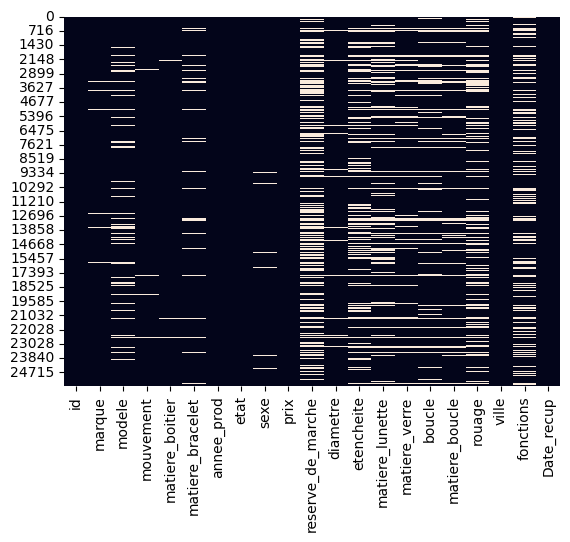

In [60]:
# Aperçu des valeurs manquantes
print(df.isnull().sum())

# Heatmap des valeurs manquantes
sns.heatmap(df.isnull(), cbar=False)

print(round(df.isnull().sum()/len(df)*100,2))


In [61]:
# Retrait des lignes pour lesquelles les valeurs des variables ne sont pas renseignées.
# Au vue de la faible proportion que représentent ces lignes, on peut simplement les retirées sans crainte de perte d'information consiérable. 

df = df.dropna(subset=['marque','modele','mouvement'])

In [62]:
# Fonction pour remplir les valeurs manquantes de certaines variables en fonction de la marque, du modèle et du mouvement
def remplissage(df, variable):
    for index, row in df.iterrows():
        if pd.isna(row[variable]) or row[variable] == '[]':
            similar_rows = df[
                (df['marque'] == row['marque']) &
                (df['modele'] == row['modele']) &
                (df['mouvement'] == row['mouvement']) &
                df[variable].notna()
            ]
            if not similar_rows.empty:
                df.at[index, variable] = similar_rows[variable].iloc[0]
    return df

In [63]:
# Fonction pour remplir les valeurs manquantes de la variable mouvement qui sont égales à = [] en fonction de la marque, du modèle et du mouvement
def remplissage_mouvement(df, variable):
    for index, row in df.iterrows():
        if pd.isna(row[variable]):
            similar_rows = df[
                (df['marque'] == row['marque']) &
                (df['modele'] == row['modele']) &
                (df['mouvement'] == '[]') & 
                df[variable].notna()
            ]
            if not similar_rows.empty:
                df.at[index, variable] = similar_rows[variable].iloc[0]
    return df

In [64]:
def remplissage_reserve_marche(df, variable):
    for index, row in df.iterrows():
        if pd.isna(row[variable]) or row[variable] == '[]':
            # Vérifier si row['rouage'] est une chaîne de caractères
            if isinstance(row['rouage'], str):
                similar_rows = df[
                    (row['rouage'].startswith('Quar') or row['rouage'].startswith('ETA')) &
                    df[variable].notna()
                ]
                if not similar_rows.empty:
                    df.at[index, variable] = 'Pas_de_reserve'
            else:
                # Gérer les cas où row['rouage'] n'est pas une chaîne de caractères (par exemple, NaN ou float)
                # Vous pouvez soit ignorer ces lignes, soit les gérer différemment selon vos besoins
                continue
    return df


In [65]:
df = remplissage_reserve_marche(df, 'reserve_de_marche')

In [66]:
df = remplissage(df,'matiere_boitier')
df = remplissage(df,'matiere_bracelet')
df = remplissage(df,'sexe')
df = remplissage(df, 'diametre')
df = remplissage(df,'etencheite')
df = remplissage(df, 'matiere_lunette')
df = remplissage(df, 'matiere_verre')
df = remplissage(df,'boucle')
df = remplissage(df,'matiere_boucle')
df = remplissage(df,'rouage')
df = remplissage(df, 'reserve_de_marche')


In [67]:
df = remplissage_mouvement(df, 'mouvement')

In [68]:
df = df.dropna(subset=['rouage','etencheite','matiere_bracelet', 'etat', 'sexe', 'diametre', 'matiere_lunette',
                       'matiere_verre', 'boucle'])

In [69]:
# Création d'une fonction pour la création d'une variable pour compter le nombre de complications que possède la montre
def count_functions(fonction_string):
    if pd.isna(fonction_string):
        return 0
    if 'Fonctions\n' in fonction_string:
        fonctions_part = fonction_string.split('Fonctions\n')[1]
        # Diviser par les virgules et les espaces pour obtenir les fonctions
        fonctions_list = [func.strip() for func in fonctions_part.split(',')]
        return len(fonctions_list)
    elif 'Autres\n' in fonction_string:
        fonctions_part = fonction_string.split('Autres\n')[1]
        # Diviser par les virgules et les espaces pour obtenir les fonctions
        fonctions_list = [func.strip() for func in fonctions_part.split(',')]
        return len(fonctions_list)
    else:
        return 'Non_renseignée'
    

In [70]:
df['Complications'] = df['fonctions'].apply(count_functions)

In [71]:
def remplissage_mouvement_bis(df, variable):
    for index, row in df.iterrows():
        if row[variable] == '[]':
            df.at[index, variable] = 'Quartz'
    return df

In [72]:
def remplissage_mat_verre(df, variable):
    for index, row in df.iterrows():
        if row[variable] == '[]':
            df.at[index, variable] = 'Inconnue'
    return df

In [73]:
def remplissage_reserve_marche_bis(df, variable):
    # Utiliser des opérations vectorisées pour identifier les lignes à modifier
    masque = (df[variable].isna()) & (df['mouvement'] == 'Quartz')
    
    # Appliquer la valeur 'Pas_de_reserve' aux lignes identifiées
    df.loc[masque, variable] = 'Pas_de_reserve'
    
    return df

In [74]:
df = remplissage_mouvement_bis(df, 'mouvement')

In [75]:
df = remplissage_mat_verre(df, 'matiere_verre')

In [76]:
df = remplissage_reserve_marche_bis(df, 'reserve_de_marche')

In [77]:
df = df[df['matiere_boitier'] != '[]']
df = df.drop(columns=['rouage', 'fonctions','id'])
df = df.dropna(subset=['reserve_de_marche'])

# Traitement de la variable *Marque* : 

In [78]:
df['marque'] = df['marque'].astype(str)
marque = [i.replace('&', '') for i in df['marque']]
marque = [i.strip("['").strip("']")for i in marque]
marque = [i.replace(',','') for i in marque]
marque = [i.replace("''",'').replace(" ",'').replace("''",'_').replace('-','_') for i in marque]
marque = [i.upper() for i in marque]
df['marque'] = marque
df['marque'] = df['marque'].astype('category')

# Traitement de la variable *Modele* : 

In [79]:
modele = [''.join(i.split(",")[0:2]) for i in df['modele']]
modele = [i.strip("['").strip("']").replace(',','').replace(' ','').replace("''","_") for i in modele]
modele = [i.upper() for i in modele]
df['modele'] = modele
df['modele'] = df['modele'].astype('category')

In [80]:
#seuil = 100
#freq_apparition = df['modele'].value_counts()
#df['modele'] = df['modele'].apply(lambda x: x if freq_apparition[x] > seuil else 'RARE')

In [81]:
mapping = {
    'DATEJUST_36' : 'DATEJUST',
    'DATEJUST_41' : 'DATEJUST',
    'DATEJUST_31' : 'DATEJUST',
    'BLACK_BAY_FIFTY-EIGHT' : 'BLACK_BAY',
    'OYSTER_PERPETUAL_36' : 'OYSTER_PERPETUAL',
    'OYSTER_PERPETUAL_31': 'OYSTER_PERPETUAL',
    'LADY-DATEJUST' : 'LADY_DATEJUST' 
}

df['modele'] = df['modele'].replace(mapping)

# Traitement de la variable *Mouvement* : 

In [83]:
df['mouvement'] = df['mouvement'].replace({"['28000', 'A/h']": "automatique"})
mouvement = [i.strip("['").strip("']").replace(',','').replace(' ','') for i in df['mouvement']]
mouvement = [i.upper() for i in mouvement]
df['mouvement'] = mouvement
df['mouvement'] = df['mouvement'].astype('category')

# Traitement de la variable *Matiere_bracelet*

In [84]:
matiere_bracelet = [i.replace('mm)','Inconnue').replace("mm",'Inconnue').replace('/',"_") for i in df['matiere_bracelet']]
matiere_bracelet =  [i.upper() for i in matiere_bracelet]
df['matiere_bracelet'] = matiere_bracelet
df['matiere_bracelet'] = df['matiere_bracelet'].astype('category')

valeurs_a_remplacer = ['BRACELET','ROSE','NOIR','JAUNE',
                       'BRUN','BLANC','VERT','GRIS','BLEU','BORDEAUX',
                       'BEIGE']
df['matiere_bracelet'] = df['matiere_bracelet'].replace(valeurs_a_remplacer, "INCONNUE")
df['matiere_bracelet'] = df['matiere_bracelet'].replace({"D'AUTRUCHE" : "CUIR_AUTRUCHE",
                                                         "ARGENTÉ" : "ARGENT",
                                                         "VACHE" : "CUIR_VACHE"})

# Traitement de la variable *Matiere_boitier* 

In [85]:
matiere_boitier = [i.strip(']').strip('[') for i in df['matiere_boitier']]
matiere_boitier = [i.replace("', '","_").replace("'",'').replace('/','_') for i in matiere_boitier]
matiere_boitier = [i.upper() for i in matiere_boitier]
df['matiere_boitier'] = matiere_boitier
df['matiere_boitier'] = df['matiere_boitier'].astype('category')

# Traitement de la variable Etat

In [86]:
etat = [i.replace("[", "").replace("]", "").replace("'", "").replace("\"", "").replace("(", "").replace(")", "") for i in df['etat']]
etat = [i.split(",")[0:2] for i in etat]
etat = [''.join(sous_liste).strip() for sous_liste in etat]
df['etat'] = etat
df['etat'] = df['etat'].astype('category')

In [87]:
# Dictionnaire de regroupement des modalités
regroupement_modalites = {
    'Neuf/Très bon': [
        'Très bon', 'Neuve Neuve', 'Neuf', 'Aucune trace', 'État neuf', 'dorigine/Pièces originales', 'Jamais portée'
    ],
    'Bon/Satisfaisant': [
        'Bon Traces', 'Satisfaisant Traces', 'Doccasion Bon', 'Doccasion Très', 'Doccasion Satisfaisant', 'Légères traces', 'Traces dusure', 'Doccasion :'
    ],
    'Défectueux': ['Défectueux Fortement'],
    'Incomplet': ['Incomplet Éléments', 'Doccasion Incomplet']
}

# Fonction pour obtenir la nouvelle modalité basée sur la codification minimaliste
def obtenir_nouvelle_modalite(modalite):
    for nouvelle_modalite, modalites_orig in regroupement_modalites.items():
        if modalite in modalites_orig:
            return nouvelle_modalite
    return 'Autre'  # Pour gérer les cas non couverts

# Exemple d'utilisation
modalites_simplifiees = [obtenir_nouvelle_modalite(mod) for mod in df['etat']]

In [88]:
df['etat'] = modalites_simplifiees

In [89]:
mapping = {
    'Neuf/Très bon' : 'NEUF',
    'Bon/Satisfaisant' : 'SATISFAISANT',
    'Incomplet' :'INDETERMINE',
    'Autre' :'INDETERMINE',
    'Défectueux' : 'DEFECTUEUX'
} 


df['etat'] = df['etat'].replace(mapping)

# Traitement de la variable sexe 

In [90]:
df['sexe'] = df['sexe'].replace({'homme/Unisexe' : "HOMME"})
sexe = [i.upper() for i in df['sexe']]
df['sexe'] = sexe
df['sexe'] = df['sexe'].astype('category')

# Traitement de la variable prix :

In [91]:
def extraire_elements_avant_euro(chaine):
    # Convertir la chaîne en liste Python
    liste = eval(chaine)
    
    # Initialiser une liste vide pour les résultats
    sous_liste = []
    
    # Vérifier si '€)' ou '€' est dans la liste
    if '€)' in liste:
        # Trouver l'index de '€)'
        index_fin = liste.index('€)')
        
        # Extraire les deux éléments précédant '€)' s'ils existent
        if index_fin >= 2:
            sous_liste = liste[index_fin-2:index_fin]
        else:
            sous_liste = liste[:index_fin]
    elif '€' in liste:
        # Trouver l'index de '€'
        index_fin = liste.index('€')
        
        # Extraire les deux éléments précédant '€' s'ils existent
        if index_fin >= 2:
            sous_liste = liste[index_fin-2:index_fin]
        else:
            sous_liste = liste[:index_fin]
    
    return sous_liste

In [92]:
df['prix'] = df['prix'].apply(extraire_elements_avant_euro)

In [93]:
prix = [''.join(sous_liste).strip() for sous_liste in df['prix']]
prix = [i.replace("(=","") for i in prix]
df['prix'] = prix
df = df[df['prix'] != '']
df['prix'] = df['prix'].astype('float')

# Traitement de la variable réserve de marche 

In [94]:
# Fonction pour extraire les éléments spéciaux
def extraire_elements_h(chaine):
    # Gérer le cas spécial 'Pas_de_reserve'
    if chaine == 'Pas_de_reserve':
        return 0
    if chaine == '[Ultra, Thin, Réserve, de, Marche]':
        return 0
    
    # Convertir la chaîne en liste Python
    liste = eval(chaine)
    
    # Vérifier si 'h' est dans la liste
    if 'h' in liste:
        # Trouver l'index de 'h'
        index_h = liste.index('h')
        
        # Extraire l'élément précédant 'h' s'il existe
        if index_h >= 1:
            return liste[index_h-1]
        else:
            return liste[:index_h]
    
    # Si aucune des conditions n'est remplie, retourner la liste entière
    return liste

In [95]:
df['reserve_de_marche'] = df['reserve_de_marche'].apply(extraire_elements_h)

# Traitement de la variable diametre 

In [97]:
diametre = [i.split(',')[0] for i in df['diametre']]
diametre = [i.replace(" ","") for i in diametre]
diametre = [i.replace('[',"").replace("]","").replace("'",'').replace("mm","") for i in diametre]
df['diametre'] = diametre
df['diametre'] = df['diametre'].astype('float')
diametre = [math.ceil(i) for i in df['diametre']]
df['diametre'] = diametre

# Traitement de la varaible etencheite 

In [98]:
etencheite = [i.split(',')[0] for i in df['etencheite']]
etencheite = [i.replace('[',"").replace("]","").replace("'",'').replace('Non', '0').replace('Au-delà','0') for i in etencheite]
df['etencheite'] = etencheite
df['etencheite'] = df['etencheite'].astype('float')

# Traitement de la variable matiere_lunette

In [99]:
valeurs_a_remplacer = ['rose','jaune','blanc','rouge']
df['matiere_lunette'] = df['matiere_lunette'].replace(valeurs_a_remplacer, 'Indetermine')
matiere_lunette = [i.replace("/","_").upper() for i in df['matiere_lunette']]
df['matiere_lunette'] = matiere_lunette
df['matiere_lunette'] = df['matiere_lunette'].astype('category')

# Traitement de la variable matiere_verre

In [100]:
matiere_verre = [i.replace("[","").replace("]","").replace("'","") for i in df['matiere_verre']]
matiere_verre = [i.upper() for i in matiere_verre]
df['matiere_verre'] = matiere_verre
df['matiere_verre'] = df['matiere_verre'].astype('category')

# Traitement de la variable boucle 

In [101]:
boucle = [i.strip(",").replace("[","").replace("]","").replace("'","").replace(",","").replace(" ","_") for i in df['boucle']]
boucle = [i.upper() for i in boucle]
df['boucle'] = boucle
df['boucle'] = df['boucle'].astype('category')

# Traitement de la variable matiere_boucle

In [102]:
matiere_boucle = [i.strip(",").replace("[","").replace("]","").replace("'","").replace(",","").replace(" ","_").replace("/","_") for i in df['matiere_boucle']]
matiere_boucle = [i.upper() for i in matiere_boucle]
df['matiere_boucle'] = matiere_boucle
df['matiere_boucle'] = df['matiere_boucle'].astype('category')

# Traitement de la variable ville 

In [103]:
pays = [i.replace('[','').replace(']','').replace("'","") for i in df['ville']]
pays = [i.split(',')[0] for i in pays]
pays = [i.upper() for i in pays]
df = df.drop(columns=['ville'])
df['pays'] = pays
df['pays'] = df['pays'].astype('category')

In [104]:
df['pays'].unique().tolist()

['GRANDE-BRETAGNE',
 'ESPAGNE',
 'POLOGNE',
 'ALLEMAGNE',
 'FRANCE',
 'BELGIQUE',
 'ÉTATS-UNIS',
 'ITALIE',
 'AUTRICHE',
 'MONACO',
 'JAPON',
 'PAYS-BAS',
 'CORÉE',
 'SUISSE',
 'SUÈDE',
 'AUSTRALIE',
 'HONGRIE',
 'RÉPUBLIQUE',
 'CANADA',
 'ISLANDE',
 'IRLANDE',
 'DANEMARK',
 'BRÉSIL',
 'HONG',
 'GRÈCE',
 'SINGAPOUR',
 'LITUANIE',
 'SLOVÉNIE',
 'ROUMANIE',
 'BULGARIE',
 'ESTONIE',
 'PORTUGAL',
 'MALAISIE',
 'FINLANDE',
 'INDONÉSIE',
 'ALBANIE',
 'CROATIE',
 'INDE',
 'NORVÈGE',
 'THAÏLANDE',
 'SLOVAQUIE',
 'ANDORRE',
 'AFRIQUE',
 'GÉORGIE',
 'MAROC',
 'VIÊT',
 'ALGÉRIE',
 'ÉGYPTE',
 'PORTO',
 'LETTONIE',
 'SERBIE',
 'ISRAËL',
 'PHILIPPINES',
 'UKRAINE',
 'TAÏWAN',
 'ARGENTINE',
 'CHYPRE',
 'MEXIQUE',
 'MOLDAVIE',
 'QATAR',
 'BOSNIE',
 'BIÉLORUSSIE',
 'MACÉDOINE',
 'NOUVELLE-ZÉLANDE',
 'PANAMA',
 'LUXEMBOURG',
 'LIECHTENSTEIN',
 'GIBRALTAR',
 'E.A.U.',
 'LIBAN',
 'OMAN',
 'SRI',
 'COLOMBIE',
 'ÉQUATEUR',
 'KAZAKHSTAN',
 'MACAO',
 'CHILI',
 'ARABIE',
 'ARMÉNIE',
 'CHINE',
 'TURQUIE',
 'LIB

In [105]:
mapping = {
    'AFRIQUE': 'AFRIQUE_DU_SUD',
    'RÉPUBLIQUE' : 'RÉPUBLIQUE_TCHEQUE',
    'HONG' : 'HONG_KONG',
    'VIÊT' : 'VIETNAM',
    'PORTO' : 'PORTUGAL',
    'E.A.U.' : 'EMIRAT_ARABE_UNIS',
    'SRI': 'SRI_LANKA',
    'ARABIE' : 'ARABIE_SAOUDITE' 
}

df['pays'] = df['pays'].replace(mapping)

In [106]:
df['Complications'].astype('category')

0        1
1        1
2        1
3        1
5        0
        ..
26197    2
26199    1
26201    0
26202    0
26207    1
Name: Complications, Length: 14161, dtype: category
Categories (11, object): [0, 1, 2, 3, ..., 7, 8, 9, 'Non_renseignée']

In [107]:
df['Date_recup'] = pd.to_datetime(df['Date_recup'])

# Sauvegarde la BDD nettoyée :

In [108]:
df.to_csv('/Users/f.b/Desktop/Data_Science/Clock_industry/Scripts/Data/data_clean.csv')